In [1]:
#pip install fedot==0.5

In [2]:
#pip install tensorflow==2.5.2

In [3]:
#pip install numpy>=1.20.0

In [75]:
# Additional imports are required
import os 

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

##

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import sweetviz

In [76]:
#pip install sweetviz

In [77]:
#pip install autoviz

In [57]:
# Reading the data file
data=pd.read_csv(r'C:\\Users\\ANUBHAV\\Downloads\\FP-2\\Oil.csv')
#setting index as date
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']

### Explorartry Data Analysis

In [66]:
my_report  = sweetviz.analyze([data,'Train'], target_feat='OILPRODUS')
my_report.show_html('FinalReport.html')


Report FinalReport.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


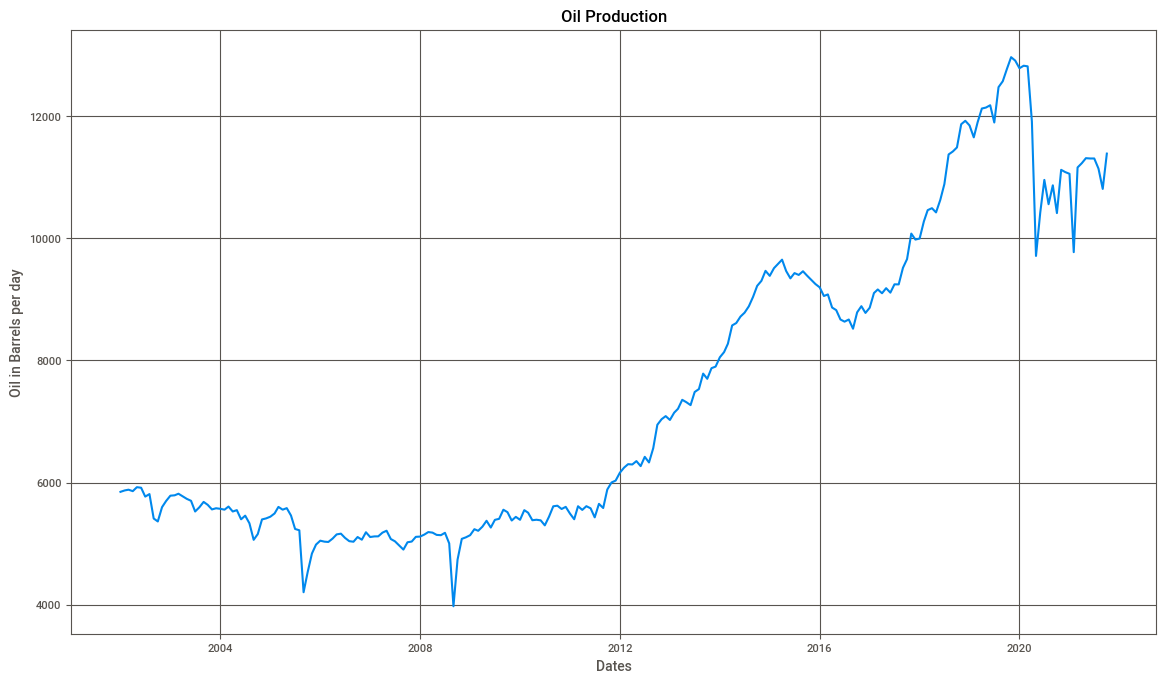

In [67]:
#plot close price
plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Oil in Barrels per day')
plt.plot(data['OILPRODUS'])
plt.title('Oil Production')
plt.show()

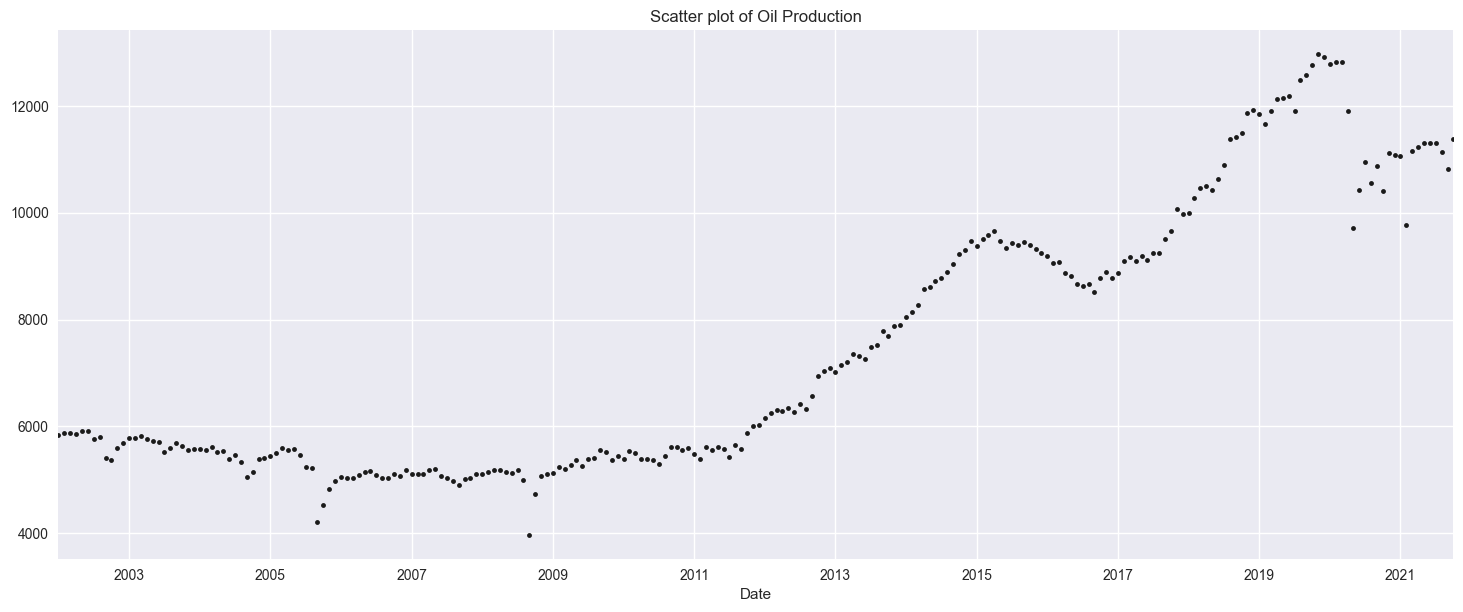

In [78]:
#Scatterplot
df_close = data['OILPRODUS']
df_close.plot(style='k.')
plt.title('Scatter plot of Oil Production')
plt.show()

#### The below function trains a linear autoregressive model, which use 2 predictors to give a forecast and the return model provides fitted linear regression model

In [34]:
def autoregression(dataframe):

    
    
    vals = dataframe['Values']
    
    
    lagged_dataframe = pd.concat([vals.shift(2), vals.shift(1), vals], axis=1)
    
    
    lagged_dataframe.columns = ['Predictor 1', 'Predictor 2', 'Target']
    
    # Drop na rows (first two rows)
    lagged_dataframe.dropna(inplace=True)
    
    
    print(lagged_dataframe.head(4))
    
    # Get linear model to train
    model = LinearRegression()
    
    
    x_train = lagged_dataframe[['Predictor 1', 'Predictor 2']]
    y_train = lagged_dataframe['Target']
    
    # model fit
    model.fit(x_train, y_train)
    return model

In [35]:
import csv
df = pd.read_csv('C:\\Users\\ANUBHAV\\Downloads\\FP-2\\Oil_prod.csv')

In [36]:
# Getting fitted model Top 5 rows values
fitted_model = autoregression(df)

   Predictor 1  Predictor 2  Target
2       5848.0       5871.0    5883
3       5871.0       5883.0    5859
4       5883.0       5859.0    5924
5       5859.0       5924.0    5915


As seen in the example, autoregressive models are necessary to model the dependence between the constituents of a time series. We utilised linear regression to approximate the relationship, although nonlinear models (such as random forest) can also be used.

These models, however, are not directly employed in the framework. They're kept in containers called "nodes."

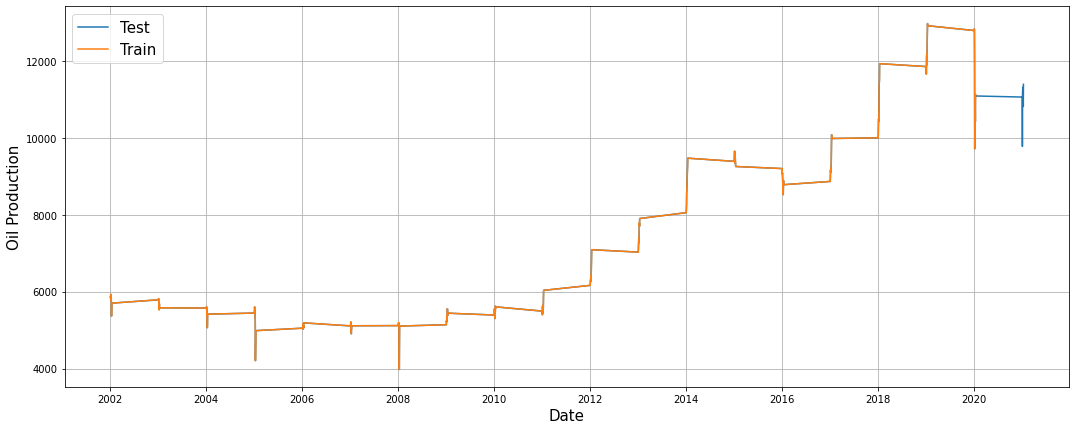

In [37]:
# Reading the data file
df['Date'] = pd.to_datetime(df['Date'])


len_forecast = 10


true_values = np.array(df['Values'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]
train_data = train_array
test_data = test_array
plt.plot(df['Date'], true_values, label = 'Test')
plt.plot(df['Date'][:-len_forecast], train_array, label = 'Train')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Oil Production', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

In [38]:
def forcast_function(train_data, len_forecast: int, window_size: int, final_model: str = 'ridge'):
    
    
    
    
    tk = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

    
    train_input = InputData(idx=np.arange(0, len(train_data)),
                            features=train_data,
                            target=train_data,
                            task=tk,
                            data_type=DataTypesEnum.ts)

    
    start_forecast = len(train_data)
    end_forecast = start_forecast + len_forecast
    
    forcst_idx = np.arange(start_forecast, end_forecast)
    prdct_input = InputData(idx=forcst_idx,
                              features=train_data,
                              target=test_data,
                              task=tk,
                              data_type=DataTypesEnum.ts)
    
    
    node_lag = PrimaryNode('lagged')
    
    
    node_lag.custom_params = {'window_size': window_size}
    node_ridge = SecondaryNode(final_model, nodes_from=[node_lag])
    ridge_pipln = Pipeline(node_ridge)

    
    ridge_pipln.fit(train_input)

    
    prdctd_op = ridge_pipln.predict(prdct_input)

    
    forecast_result = np.ravel(np.array(prdctd_op.predict))

    return forecast_result

In [39]:
#predictions
predicted_values = forcast_function(train_data=train_array, 
                                 len_forecast=10,
                                 window_size=208,
                                 final_model='ridge')

#### Function for drawing plot on predicted resultse with the entire array with one-dimensional data and including array with predicted values, number of elements in the training sample, Predicted variable i.e Oil Production name on the y axis

In [40]:
def plots(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):

    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Number of Months', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

##### Black line in plot divide our train and test array

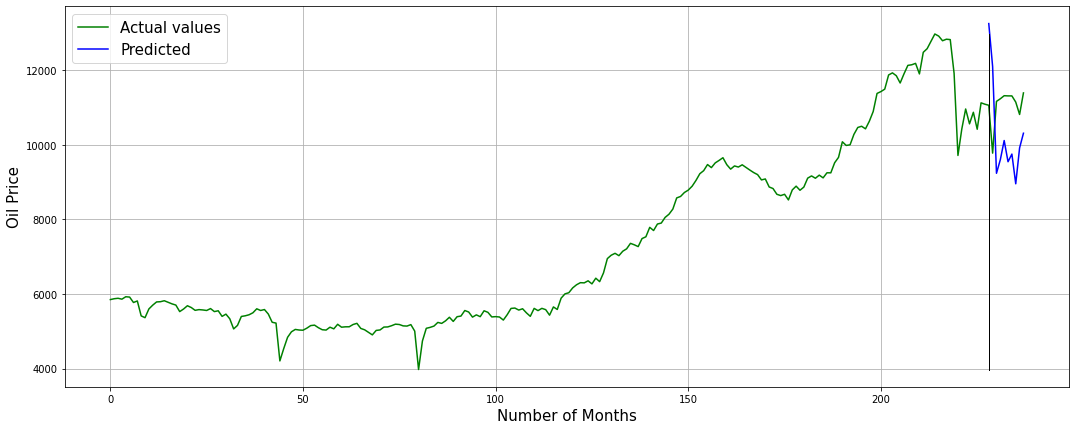

Mean absolute error: 1676.195


In [41]:

plots(actual_time_series=true_values,
             predicted_values=predicted_values, 
             len_train_data=len(train_array),
             y_name='Oil Price')


print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

In [42]:
predicted_values = forcast_function(train_data = train_array, 
                                 len_forecast = 10,
                                 window_size = 118)


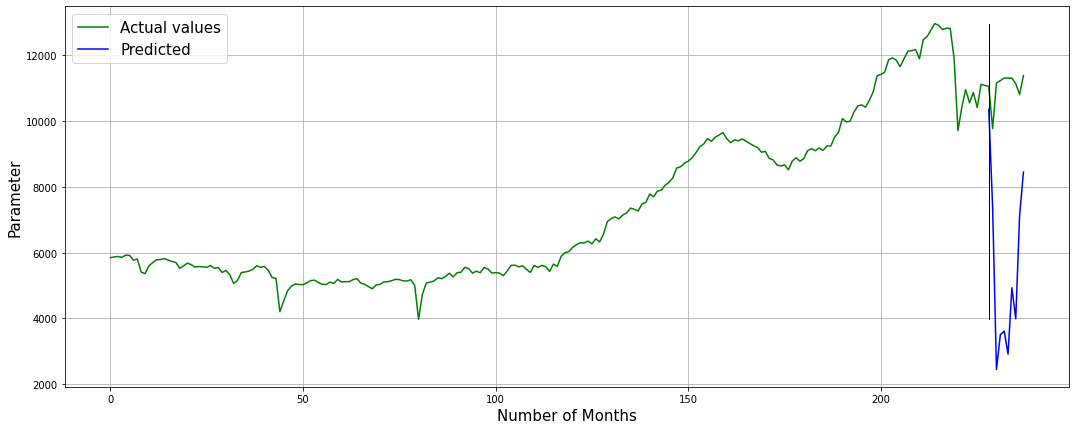

In [43]:
plots(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_data))

#### Defining below the three level for the nodes

In [44]:
# First
node_lag_1 = PrimaryNode('lagged')
node_lag_1.custom_params = {'window_size': 3}
node_lag_2 = PrimaryNode('lagged')
node_lag_2.custom_params = {'window_size': 450}

# Second
node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lag_1])
node_ridge = SecondaryNode('ridge', nodes_from=[node_lag_2])

# Third
node_final = SecondaryNode('ridge', nodes_from=[node_knnreg, node_ridge])
complex_pipeline = Pipeline(node_final)

In [45]:

tk = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=10))

# Preparing training  data
train_input = InputData(idx=np.arange(0, len(train_array)),
                        features=train_array,
                        target=train_array,
                        task=tk,
                        data_type=DataTypesEnum.ts)

# Preparing input data to make predictions
start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast
# Create indices to make the forecast
forcst_idx = np.arange(start_forecast, end_forecast)
prdct_input = InputData(idx=forcst_idx,
                          features=train_array,
                          target=None,
                          task=tk,
                          data_type=DataTypesEnum.ts)

In [46]:
size_train = np.array(train_input)
#print(size_train.shape)

In [47]:
# Fitting the pipeline
complex_pipeline.fit(train_input)

OutputData(idx=array([208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218]), features=array([[11989.2       , 11953.6       , 12114.8       , 12241.8       ,
        12427.6       , 12476.8       , 12603.6       , 12741.6       ,
        12772.8       , 12832.8       , 12141.00000394, 12178.99997532,
        11896.00015632, 12475.00001018, 12572.00004908, 12771.00005533,
        12966.00003073, 12910.00000879, 12784.99997696, 12825.99999086],
       [12068.8       , 12204.2       , 12367.8       , 12585.        ,
        12679.6       , 12665.6       , 12792.4       , 12781.8       ,
        12621.8       , 12046.        , 12178.99994843, 11896.00012052,
        12474.99987234, 12572.00005329, 12770.99999984, 12965.99998964,
        12909.99997276, 12784.99998655, 12826.0000161 , 12815.99984722],
       [12155.        , 12322.6       , 12581.8       , 12672.        ,
        12722.2       , 12676.6       , 12762.4       , 12582.        ,
        12007.        , 11564.8       , 11896.

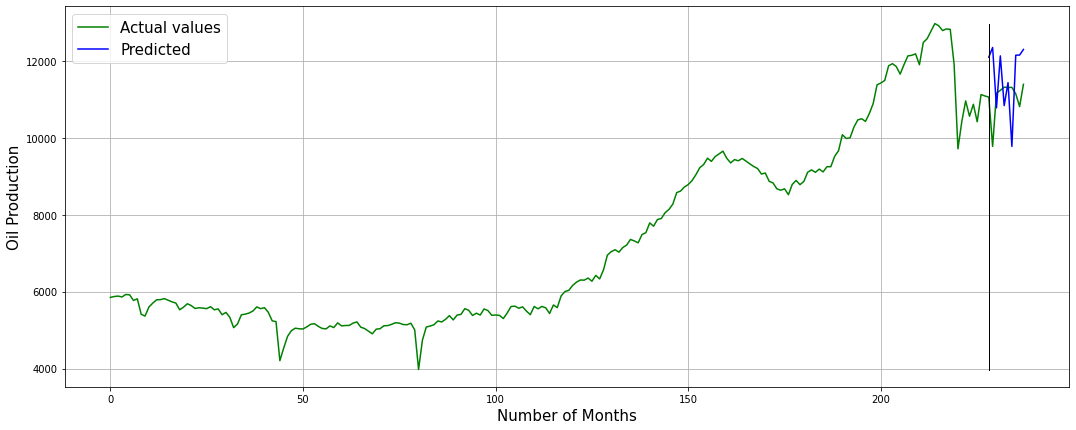

Mean absolute error: 1027.108


In [48]:
prdctd_op = complex_pipeline.predict(prdct_input)


predicted_values = np.ravel(np.array(prdctd_op.predict))


plots(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Oil Production')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

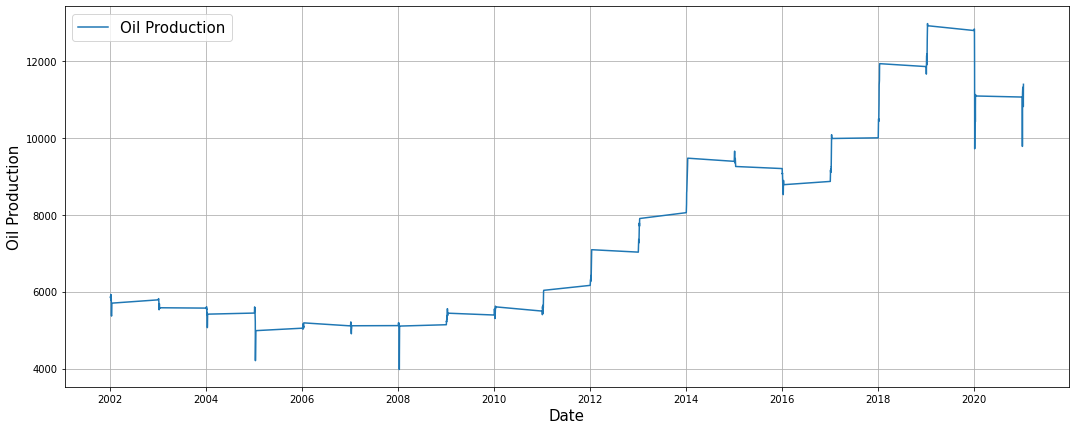

In [49]:
# Plotting the times series of oil production
plt.plot(df['Date'], df['Values'], label = 'Oil Production')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Oil Production', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

### Runnning our timeseries Oil production data on AutoML Fedot

In [50]:

len_forecast = 10
tk = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))


true_values = np.array(df['Values'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]


train_lagged = InputData(idx=np.arange(0, len(train_array)),
                         features=train_array,
                         target=train_array,
                         task=tk,
                         data_type=DataTypesEnum.ts)
start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast
predict_lagged = InputData(idx=np.arange(start_forecast, end_forecast),
                           features=train_array,
                           target=test_array,
                           task=tk,
                           data_type=DataTypesEnum.ts)

In [51]:
exog_arr = np.array(df['Values'])
exog_train = exog_arr[:-len_forecast]
exog_test = exog_arr[-len_forecast:]


train_exog = InputData(idx=np.arange(0, len(exog_train)),
                       features=exog_train,
                       target=train_array,
                       task=tk,
                       data_type=DataTypesEnum.ts)
start_forecast = len(exog_train)
end_forecast = start_forecast + len_forecast
predict_exog = InputData(idx=np.arange(start_forecast, end_forecast),
                          features=exog_test,
                          target=test_array,
                          task=tk,
                          data_type=DataTypesEnum.ts)

In [52]:
from fedot.core.data.multi_modal import MultiModalData

train_dataset = MultiModalData({
    'lagged': train_lagged,
    'exog_ts': train_exog
})

predict_dataset = MultiModalData({
    'lagged': predict_lagged,
    'exog_ts': predict_exog
})

In [53]:
 
node_lag = PrimaryNode('lagged')
node_exog = PrimaryNode('exog_ts')
node_ridge = SecondaryNode('ridge', nodes_from=[node_lag, node_exog])
exog_pipeline = Pipeline(node_ridge)

# Fitting
exog_pipeline.fit(train_dataset)

# Predicting
predicted = exog_pipeline.predict(predict_dataset)
predicted_values = np.ravel(np.array(predicted.predict))

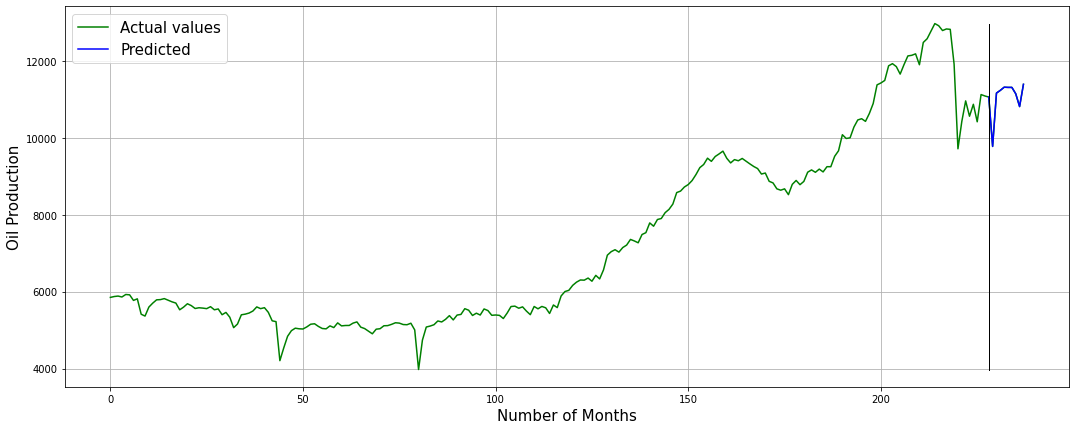

Mean absolute error: 0.000


In [54]:
plots(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Oil Production')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')